<a href="https://colab.research.google.com/github/phoebe-alexis/COVID_Prediction/blob/main/covid19_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from datetime import timedelta


In [ ]:
# Load the dataset
file_path = 'time_series_covid19_confirmed_US.csv'  # Update the path if necessary
data = pd.read_csv(file_path)

# Inspect the data
print(data.head())
print(data.info())


        UID iso2 iso3  code3    FIPS   Admin2 Province_State Country_Region  \
0  84001001   US  USA    840  1001.0  Autauga        Alabama             US   
1  84001003   US  USA    840  1003.0  Baldwin        Alabama             US   
2  84001005   US  USA    840  1005.0  Barbour        Alabama             US   
3  84001007   US  USA    840  1007.0     Bibb        Alabama             US   
4  84001009   US  USA    840  1009.0   Blount        Alabama             US   

         Lat      Long_  ... 2/28/23  3/1/23  3/2/23  3/3/23  3/4/23  3/5/23  \
0  32.539527 -86.644082  ...   19732   19759   19759   19759   19759   19759   
1  30.727750 -87.722071  ...   69641   69767   69767   69767   69767   69767   
2  31.868263 -85.387129  ...    7451    7474    7474    7474    7474    7474   
3  32.996421 -87.125115  ...    8067    8087    8087    8087    8087    8087   
4  33.982109 -86.567906  ...   18616   18673   18673   18673   18673   18673   

   3/6/23  3/7/23  3/8/23  3/9/23  
0   1975

In [ ]:
# Select columns related to COVID-19 cases
columns_to_keep = ['Province_State', 'Admin2', 'Lat', 'Long_', '5/1/20', '5/2/20', '5/3/20']  # Modify for your dataset
covid_data = data[columns_to_keep]

# Reshape the data to have dates as rows
covid_data = covid_data.melt(
    id_vars=['Province_State', 'Admin2', 'Lat', 'Long_'],
    var_name='Date',
    value_name='Cases'
)

# Convert 'Date' column to datetime
covid_data['Date'] = pd.to_datetime(covid_data['Date'])

# Check processed data
print(covid_data.head())
print("covid_data shape before grouping:", covid_data.shape)
print(covid_data.head(10))  # Check sample rows



  Province_State   Admin2        Lat      Long_       Date  Cases
0        Alabama  Autauga  32.539527 -86.644082 2020-05-01     43
1        Alabama  Baldwin  30.727750 -87.722071 2020-05-01    180
2        Alabama  Barbour  31.868263 -85.387129 2020-05-01     42
3        Alabama     Bibb  32.996421 -87.125115 2020-05-01     41
4        Alabama   Blount  33.982109 -86.567906 2020-05-01     41
covid_data shape before grouping: (10026, 6)
  Province_State    Admin2        Lat      Long_       Date  Cases
0        Alabama   Autauga  32.539527 -86.644082 2020-05-01     43
1        Alabama   Baldwin  30.727750 -87.722071 2020-05-01    180
2        Alabama   Barbour  31.868263 -85.387129 2020-05-01     42
3        Alabama      Bibb  32.996421 -87.125115 2020-05-01     41
4        Alabama    Blount  33.982109 -86.567906 2020-05-01     41
5        Alabama   Bullock  32.100305 -85.712655 2020-05-01     14
6        Alabama    Butler  31.753001 -86.680575 2020-05-01     68
7        Alabama   Calh

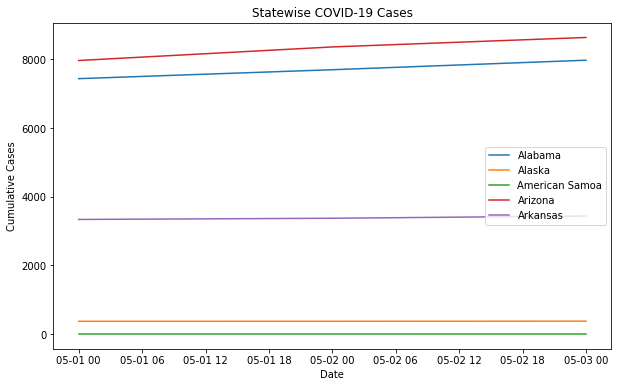

statewise_data shape after grouping: (174, 5)
   Province_State       Date          Lat        Long_  Cases
0         Alabama 2020-05-01  2203.246784 -5809.578199   7440
1         Alabama 2020-05-02  2203.246784 -5809.578199   7700
2         Alabama 2020-05-03  2203.246784 -5809.578199   7977
3          Alaska 2020-05-01  1868.733025 -4605.860811    369
4          Alaska 2020-05-02  1868.733025 -4605.860811    370
5          Alaska 2020-05-03  1868.733025 -4605.860811    373
6  American Samoa 2020-05-01   -14.271000  -170.132000      0
7  American Samoa 2020-05-02   -14.271000  -170.132000      0
8  American Samoa 2020-05-03   -14.271000  -170.132000      0
9         Arizona 2020-05-01   505.138555 -1671.948482   7969


In [ ]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()  # Register datetime converters

# Aggregate cases by state and date
statewise_data = covid_data.groupby(['Province_State', 'Date']).sum().reset_index()

# Visualize statewise trends (optional)
plt.figure(figsize=(10, 6))
for state in statewise_data['Province_State'].unique()[:5]:  # First 5 states for clarity
    state_data = statewise_data[statewise_data['Province_State'] == state]
    plt.plot(state_data['Date'], state_data['Cases'], label=state)
plt.legend()
plt.title("Statewise COVID-19 Cases")
plt.xlabel("Date")
plt.ylabel("Cumulative Cases")
plt.show()

# Aggregate cases by state and date
statewise_data = covid_data.groupby(['Province_State', 'Date']).sum().reset_index()

# Debug print to check data
print("statewise_data shape after grouping:", statewise_data.shape)
print(statewise_data.head(10))  # Check sample data



In [ ]:
# Function to create lag features
def create_lag_features(df, lag_days=1):
    df = df.copy()

    # Debugging: Check column names
    print("\n✅ Available columns in DataFrame:", df.columns)

    # Ensure "Province_State" exists
    if "Province_State" not in df.columns:
        raise KeyError("❌ 'Province_State' column not found. Check dataset!")

    # Create only 1 lag day
    df[f'Lag_{lag_days}'] = df.groupby('Province_State')['Cases'].shift(lag_days)

    # Drop only the first row per group (since Lag_1 will be NaN)
    df = df.dropna().reset_index(drop=True)

    print("\n✅ Data AFTER fixing NaN issue:", df.shape)
    print(df.head(10))  # Check sample data

    return df

# Create lag features
statewise_data = create_lag_features(statewise_data, lag_days=1)



✅ Available columns in DataFrame: Index(['Province_State', 'Date', 'Lat', 'Long_', 'Cases'], dtype='object')

✅ Data AFTER fixing NaN issue: (116, 6)
   Province_State       Date          Lat        Long_  Cases   Lag_1
0         Alabama 2020-05-02  2203.246784 -5809.578199   7700  7440.0
1         Alabama 2020-05-03  2203.246784 -5809.578199   7977  7700.0
2          Alaska 2020-05-02  1868.733025 -4605.860811    370   369.0
3          Alaska 2020-05-03  1868.733025 -4605.860811    373   370.0
4  American Samoa 2020-05-02   -14.271000  -170.132000      0     0.0
5  American Samoa 2020-05-03   -14.271000  -170.132000      0     0.0
6         Arizona 2020-05-02   505.138555 -1671.948482   8364  7969.0
7         Arizona 2020-05-03   505.138555 -1671.948482   8640  8364.0
8        Arkansas 2020-05-02  2618.391704 -6932.548370   3372  3337.0
9        Arkansas 2020-05-03  2618.391704 -6932.548370   3437  3372.0


In [ ]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
features = ["Lat", "Long_", "Lag_1"]  # Input features
target = "Cases"  # Output prediction target

X = statewise_data[features]
y = statewise_data[target]

# Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print shapes to confirm
print(f"✅ Shape of X_train: {X_train.shape}, X_test: {X_test.shape}")
print(f"✅ Shape of y_train: {y_train.shape}, y_test: {y_test.shape}")


✅ Shape of X_train: (92, 3), X_test: (24, 3)
✅ Shape of y_train: (92,), y_test: (24,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize and train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5  # Root Mean Squared Error

# Print evaluation metrics
print(f"✅ Model Training Completed!")
print(f"📊 Mean Absolute Error (MAE): {mae:.2f}")
print(f"📊 Root Mean Squared Error (RMSE): {rmse:.2f}")


✅ Model Training Completed!
📊 Mean Absolute Error (MAE): 389.88
📊 Root Mean Squared Error (RMSE): 762.39


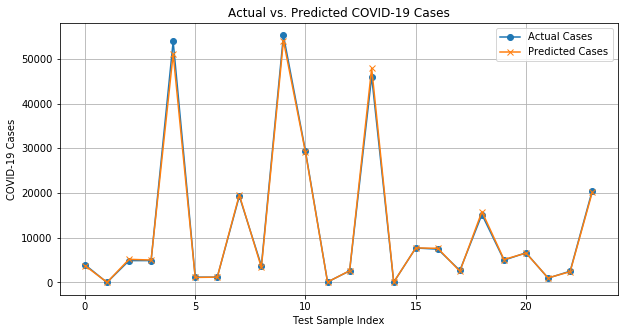

In [ ]:
import matplotlib.pyplot as plt

# Fix: Set a font that supports emojis
plt.rcParams['font.family'] = 'DejaVu Sans'  # Supports most Unicode characters

# Plot Actual vs. Predicted Cases
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label="Actual Cases", marker='o')
plt.plot(y_pred, label="Predicted Cases", marker='x')

plt.xlabel("Test Sample Index")
plt.ylabel("COVID-19 Cases")
plt.title("Actual vs. Predicted COVID-19 Cases")  # Removed emoji to prevent issue
plt.legend()
plt.grid(True)

plt.show()


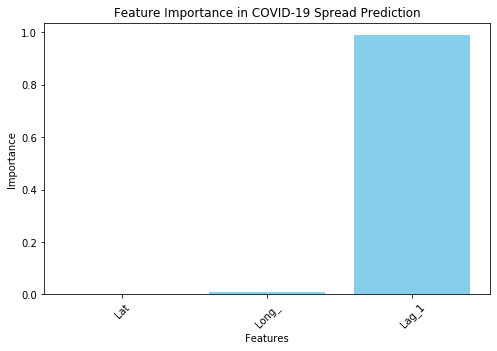

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get feature importance from the trained model
feature_importance = model.feature_importances_

# Create a bar plot for feature importance
plt.figure(figsize=(8, 5))
plt.bar(features, feature_importance, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance in COVID-19 Spread Prediction')
plt.xticks(rotation=45)
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Print best parameters
print("✅ Best Parameters:", grid_search.best_params_)

# Train model with best parameters
best_model = RandomForestRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_tuned = best_model.predict(X_test)
mae_tuned = mean_absolute_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))

print(f"📊 MAE (Tuned): {mae_tuned:.2f}")
print(f"📊 RMSE (Tuned): {rmse_tuned:.2f}")


C:\Users\RAFA\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


✅ Best Parameters: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
📊 MAE (Tuned): 337.43
📊 RMSE (Tuned): 690.12


In [ ]:
import joblib

# Save the best model
joblib.dump(best_model, 'covid19_spread_model.pkl')

# Load the model (if needed later)
loaded_model = joblib.load('covid19_spread_model.pkl')


Predicting for Alabama on 2020-05-04 00:00:00
Lag_1 feature for prediction: 7977
Predicted cases for Alabama on 2020-05-04 00:00:00: 8408.96
Predicting for Alabama on 2020-05-05 00:00:00
Lag_1 feature for prediction: 8408.96
Predicted cases for Alabama on 2020-05-05 00:00:00: 8679.62
Predicting for Alabama on 2020-05-06 00:00:00
Lag_1 feature for prediction: 8679.62
Predicted cases for Alabama on 2020-05-06 00:00:00: 8998.58
Predicting for Alabama on 2020-05-07 00:00:00
Lag_1 feature for prediction: 8998.58
Predicted cases for Alabama on 2020-05-07 00:00:00: 9154.35
Predicting for Alabama on 2020-05-08 00:00:00
Lag_1 feature for prediction: 9154.35
Predicted cases for Alabama on 2020-05-08 00:00:00: 9210.53
Predicting for Alabama on 2020-05-09 00:00:00
Lag_1 feature for prediction: 9210.53
Predicted cases for Alabama on 2020-05-09 00:00:00: 9210.53
Predicting for Alabama on 2020-05-10 00:00:00
Lag_1 feature for prediction: 9210.53
Predicted cases for Alabama on 2020-05-10 00:00:00: 921

C:\Users\RAFA\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


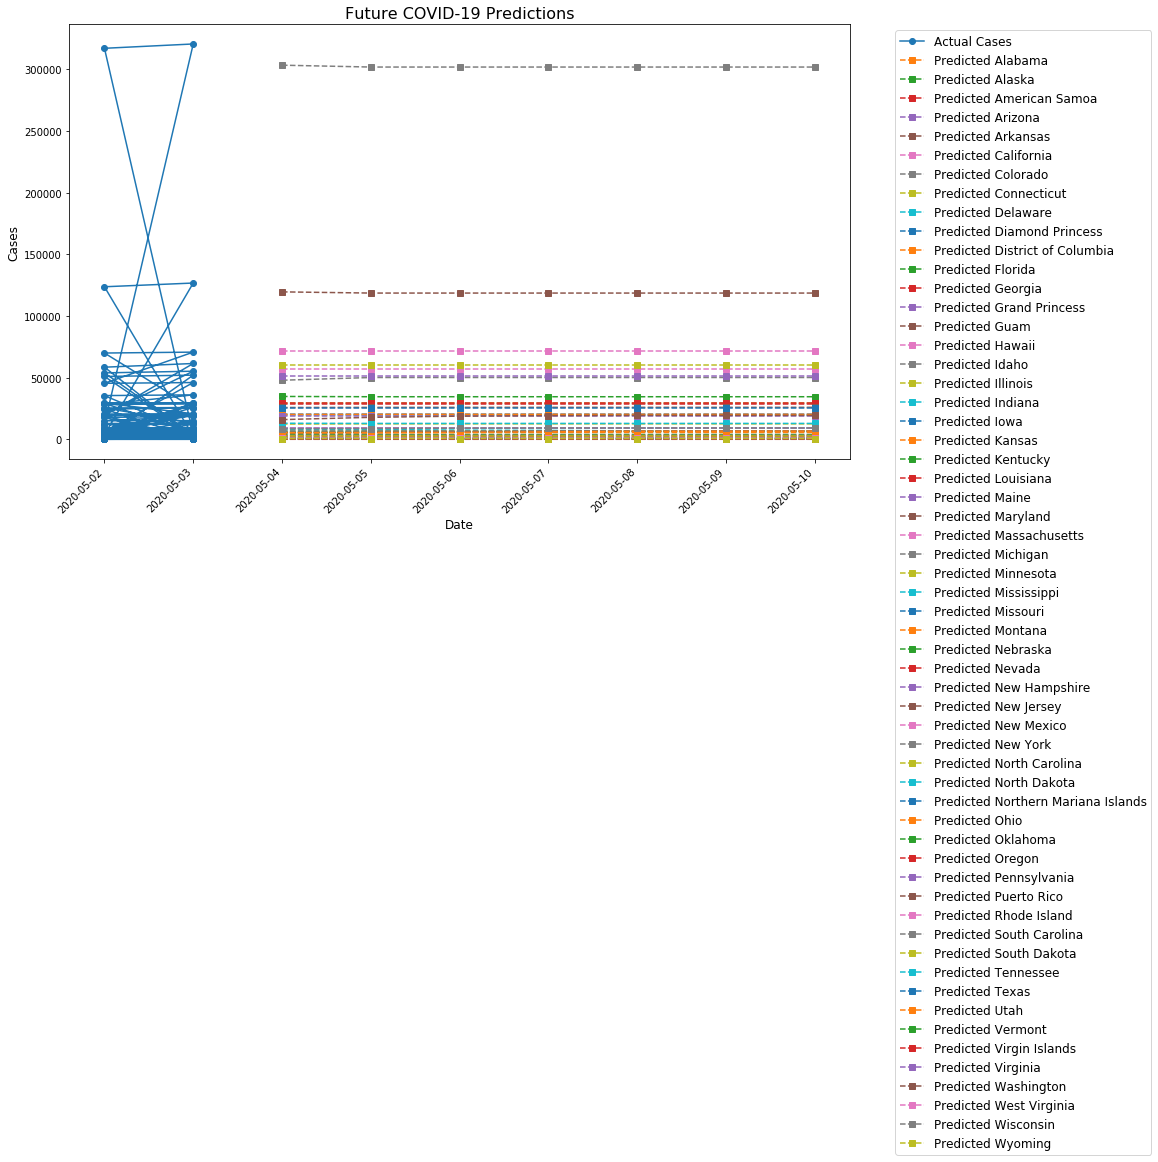

📅 Future Predictions for the Next 7 Days:
   Province_State       Date    Cases
1         Alabama 2020-05-04  8408.96
1         Alabama 2020-05-05  8679.62
1         Alabama 2020-05-06  8998.58
1         Alabama 2020-05-07  9154.35
1         Alabama 2020-05-08  9210.53
1         Alabama 2020-05-09  9210.53
1         Alabama 2020-05-10  9210.53
3          Alaska 2020-05-04   400.72
3          Alaska 2020-05-05   400.72
3          Alaska 2020-05-06   400.72
3          Alaska 2020-05-07   400.72
3          Alaska 2020-05-08   400.72
3          Alaska 2020-05-09   400.72
3          Alaska 2020-05-10   400.72
5  American Samoa 2020-05-04    20.12
5  American Samoa 2020-05-05    22.36
5  American Samoa 2020-05-06    22.36
5  American Samoa 2020-05-07    22.36
5  American Samoa 2020-05-08    22.36
5  American Samoa 2020-05-09    22.36


In [ ]:
from datetime import timedelta
import pandas as pd
import matplotlib.pyplot as plt

# Define the number of days to predict into the future
future_days = 7
latest_date = statewise_data["Date"].max()

# Create an empty DataFrame for future predictions
future_dates = [latest_date + timedelta(days=i) for i in range(1, future_days + 1)]
future_df = pd.DataFrame({"Date": future_dates})

# Get the unique list of states
states = statewise_data["Province_State"].unique()

# Prepare an empty list to collect the future predictions
all_future_predictions = []

# Loop over each state to generate predictions
for state in states:
    state_data = statewise_data[statewise_data["Province_State"] == state].copy()
    latest_data = state_data[state_data["Date"] == latest_date].copy()  # Start with the latest date for this state

    future_predictions = []
    predicted_cases = None  # Initialize predicted_cases variable

    for i, date in enumerate(future_dates):
        latest_data["Date"] = date  # Update date for prediction

        # Update Lag_1 dynamically using the last predicted cases
        if predicted_cases is not None:
            latest_data["Lag_1"] = predicted_cases  # Use the previous day's predicted cases as lag feature
        else:
            latest_data["Lag_1"] = latest_data["Cases"].iloc[-1]  # The first prediction uses the last known cases

        # Debugging: print Lag_1 before prediction
        print(f"Predicting for {state} on {date}")
        print(f"Lag_1 feature for prediction: {latest_data['Lag_1'].iloc[0]}")  # Print the lag feature

        # Predict future cases for this state
        X_future = latest_data[["Lat", "Long_", "Lag_1"]]
        predicted_cases = model.predict(X_future)  # Get the predicted cases

        # Debugging: print the predicted cases for the current date
        print(f"Predicted cases for {state} on {date}: {predicted_cases[0]}")

        # Store predictions for this date
        latest_data["Cases"] = predicted_cases
        future_predictions.append(latest_data.copy())

    # Concatenate the state-specific future predictions
    state_future_df = pd.concat(future_predictions)
    all_future_predictions.append(state_future_df)

# Concatenate all states' future predictions into one DataFrame
future_df = pd.concat(all_future_predictions)

# 📊 Visualize Future Cases
plt.figure(figsize=(14, 8))  # Increase the figure size

plt.plot(statewise_data["Date"], statewise_data["Cases"], label="Actual Cases", marker='o')

# Plot predictions for each state separately
for state in states:
    state_future = future_df[future_df["Province_State"] == state]
    plt.plot(state_future["Date"], state_future["Cases"], label=f"Predicted {state}", linestyle="dashed", marker='s')

# Add labels, title, and grid
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.title("Future COVID-19 Predictions", fontsize=16)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add a legend, and move it outside the plot area
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()

# Display the plot
plt.show()

# Display predictions for the next 7 days for each state
print("📅 Future Predictions for the Next 7 Days:")
print(future_df[["Province_State", "Date", "Cases"]].head(20))  # Show the first 20 rows for preview


C:\Users\RAFA\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 


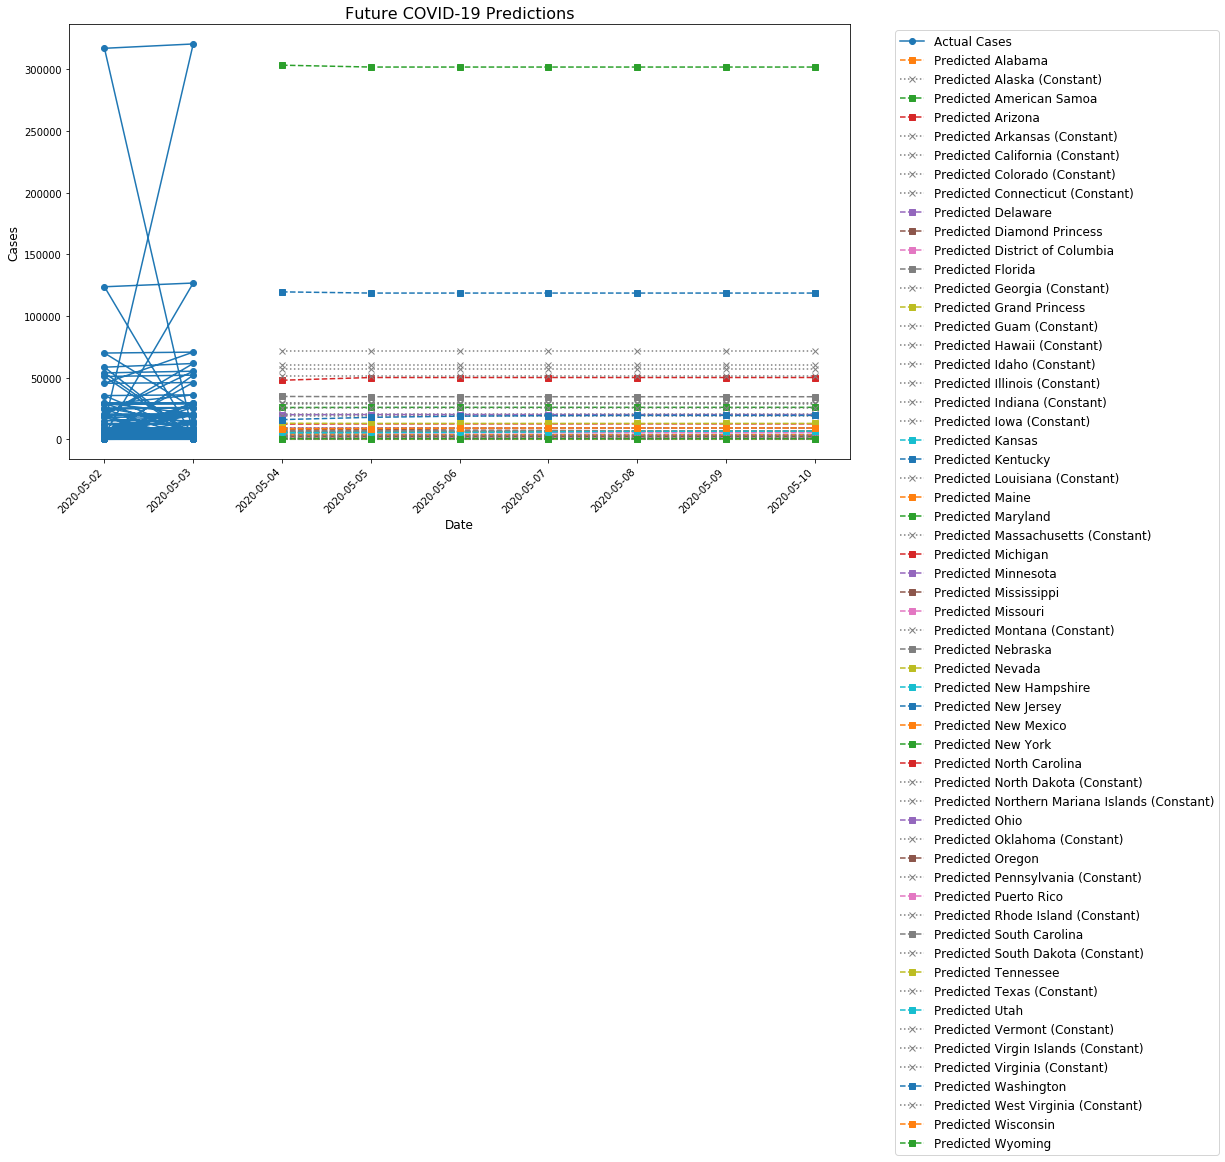

In [ ]:
# Visualize the predictions for states with constant values
plt.figure(figsize=(14, 8))  # Increase the figure size

plt.plot(statewise_data["Date"], statewise_data["Cases"], label="Actual Cases", marker='o')

# Plot predictions for each state separately
for state in states:
    state_future = future_df[future_df["Province_State"] == state]

    # Check if the predicted cases are constant
    if state_future["Cases"].nunique() == 1:  # If only one unique value exists, predictions are constant
        plt.plot(state_future["Date"], state_future["Cases"], label=f"Predicted {state} (Constant)", linestyle="dotted", marker='x', color='gray')
    else:
        plt.plot(state_future["Date"], state_future["Cases"], label=f"Predicted {state}", linestyle="dashed", marker='s')

# Add labels, title, and grid
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cases", fontsize=12)
plt.title("Future COVID-19 Predictions", fontsize=16)

# Rotate x-axis labels to avoid overlap
plt.xticks(rotation=45, ha="right", fontsize=10)

# Add a legend, and move it outside the plot area
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), fontsize=12)

# Adjust layout to prevent clipping of labels and legend
plt.tight_layout()

# Display the plot
plt.show()
